In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#plt.style.use('seaborn-whitegrid')

font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 12}
font = {'family' : 'sans serif',
        'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)


# Aux functions

def plot_grid(Xs, Ys, axs=None):
    ''' Aux function to plot a grid'''
    t = np.arange(Xs.size) # define progression of int for indexing colormap
    if axs:
        axs.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        axs.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        axs.axis('scaled') # axis scaled
    else:
        plt.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        plt.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        plt.axis('scaled') # axis scaled
        
def linear_map(A, Xs, Ys):
    '''Map src points with A'''
    # [NxN,NxN] -> NxNx2 # add 3-rd axis, like adding another layer
    src = np.stack((Xs,Ys), axis=Xs.ndim)
    # flatten the first two dimension
    # (NN)x2
    src_r = src.reshape(-1,src.shape[-1]) #ask reshape to keep last dimension and adjust the rest
    # 2x2 @ 2x(NN)
    dst = A @ src_r.T # 2xNN
    #(NN)x2 and then reshape as NxNx2
    dst = (dst.T).reshape(src.shape)
    # Access X and Y
    return dst[...,0], dst[...,1]


def plot_points(ax, Xs, Ys, col='red', unit=None, linestyle='solid'):
    '''Plots points'''
    ax.set_aspect('equal')
    ax.grid(True, which='both')
    ax.axhline(y=0, color='gray', linestyle="--")
    ax.axvline(x=0, color='gray',  linestyle="--")
    ax.plot(Xs, Ys, color=col)
    if unit is None:
        plotVectors(ax, [[0,1],[1,0]], ['gray']*2, alpha=1, linestyle=linestyle)
    else:
        plotVectors(ax, unit, [col]*2, alpha=1, linestyle=linestyle)

def plotVectors(ax, vecs, cols, alpha=1, linestyle='solid'):
    '''Plot set of vectors.'''
    for i in range(len(vecs)):
        x = np.concatenate([[0,0], vecs[i]])
        ax.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                   alpha=alpha, linestyle=linestyle, linewidth=2)

In [4]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [5]:
faces.images[0,...].shape

(62, 47)

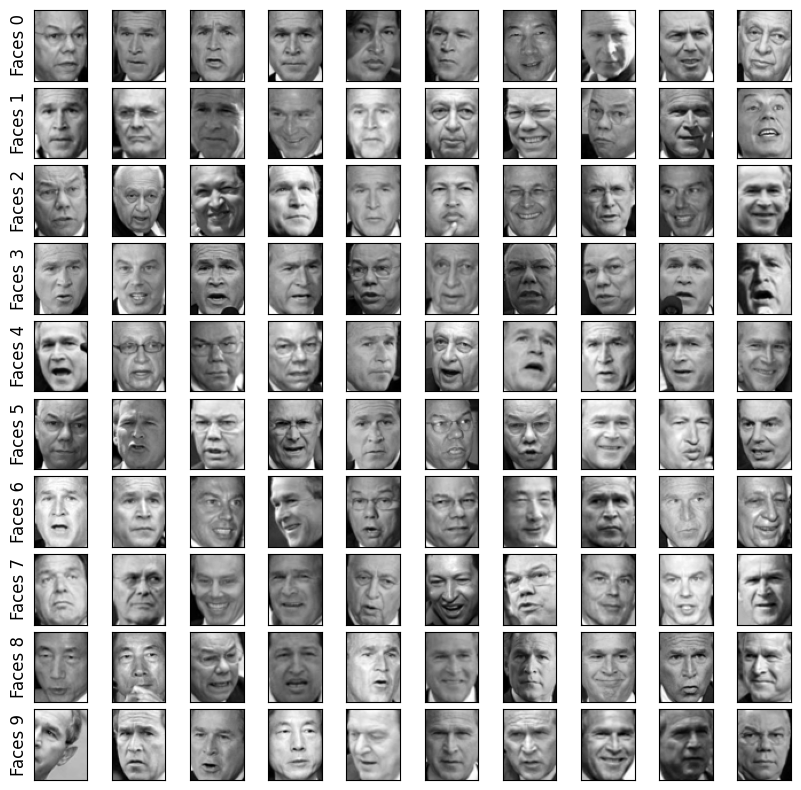

In [6]:
# Plot the faces
N_ax, N_img = 10, 10 #10 rows with 10 images per row
fig, ax = plt.subplots(N_ax, N_img,figsize=(10,10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(N_ax):
    ax[i,0].set_ylabel(f'Faces {i}')
    for j in range(N_img):
        ax[i,j].imshow(faces.data[i*N_img+j].reshape(62, 47), cmap='gray')

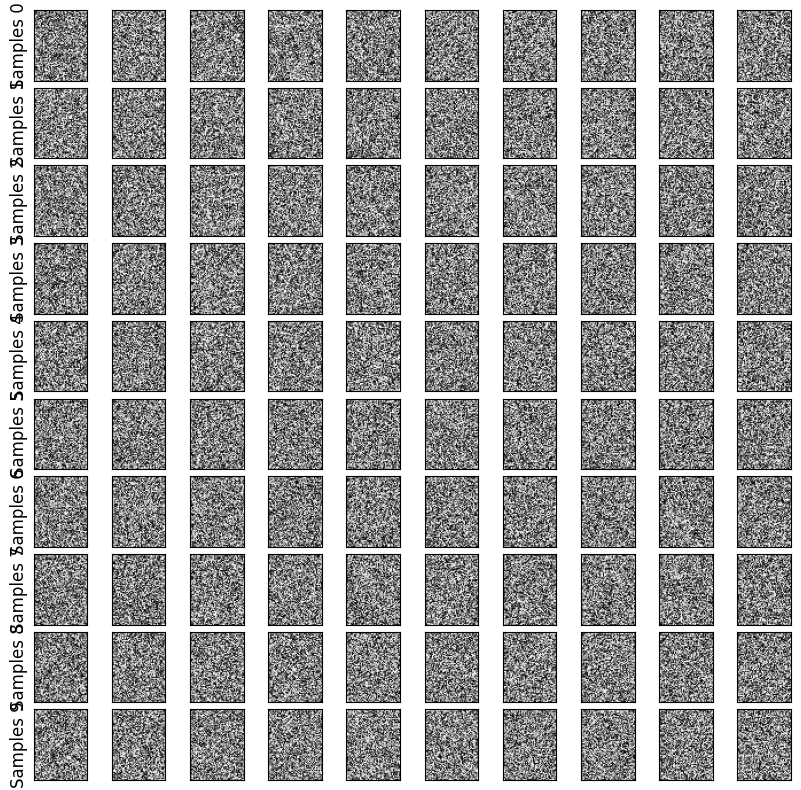

In [7]:
# Sampling
samples = np.random.uniform(0, 255, (100, 62, 47)).astype(np.uint8)
# uniformly sample 100 points in 62x47 space.

# Plot the faces
N_ax, N_img = 10, 10  # 10 rows with 10 images per row
fig, ax = plt.subplots(N_ax, N_img, figsize=(10, 10),
                       subplot_kw={'xticks': [], 'yticks': []},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(N_ax):
    ax[i, 0].set_ylabel(f'Samples {i}')
    for j in range(N_img):
        ax[i, j].imshow(samples[i*N_img+j].reshape(62, 47), cmap='gray')

In [8]:
from sklearn.decomposition import PCA 

In [9]:
pca = PCA(n_components=150) # retain 150 components
print(faces.data.shape) #NxD N=1348 samples in ~3K-D space
pca.fit(faces.data)

(1348, 2914)


PCA(n_components=150)

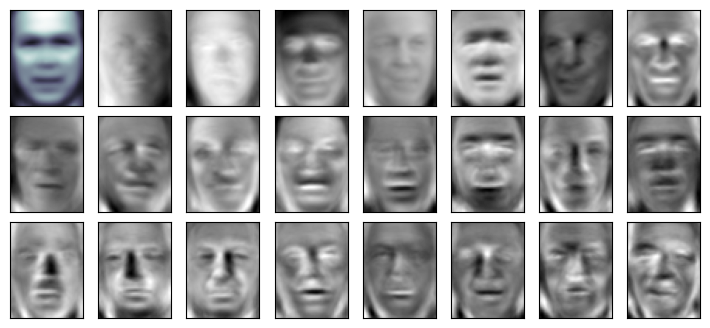

In [10]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.imshow(pca.mean_.reshape(62, 47), cmap='bone') #  plot mean
    else:
        ax.imshow(pca.components_[i].reshape(62, 47), cmap='gray') # plots components

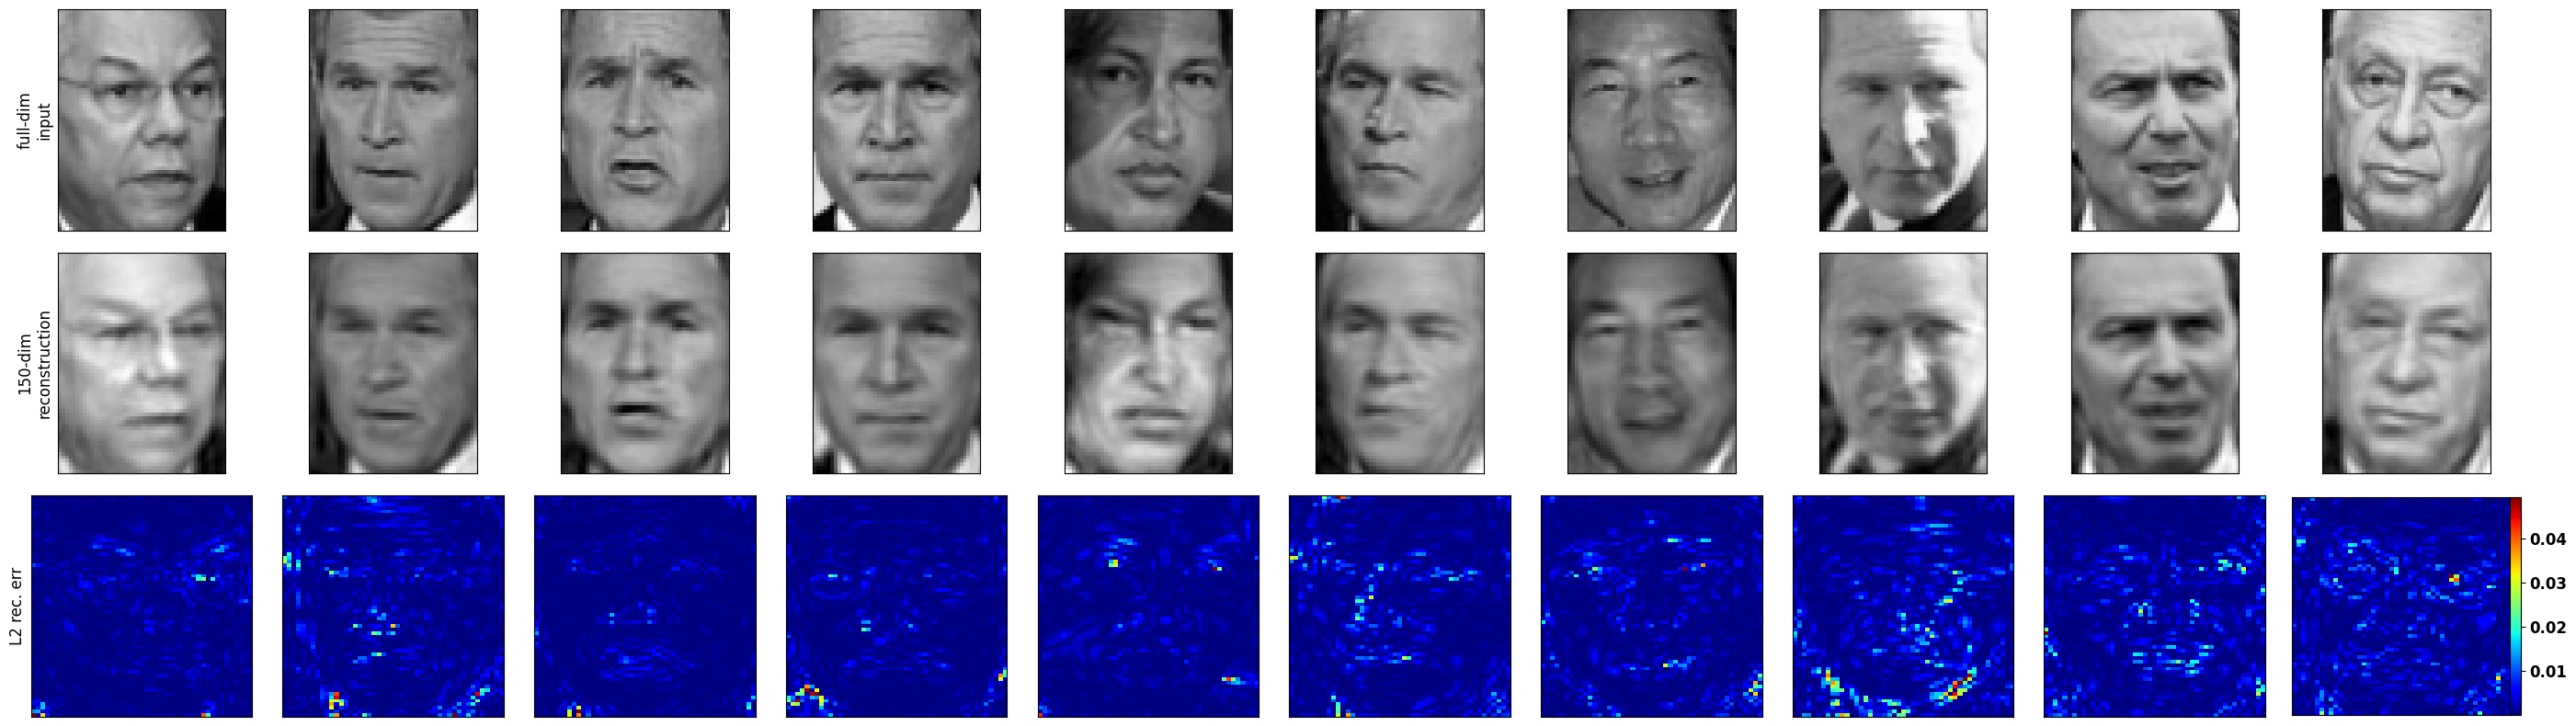

In [11]:
plt.rcParams['axes.grid'] = False
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
# Project back to the input
# Project back to the input
projected = pca.transform(faces.data) # project with P = U_t*X_t
unprojected = pca.inverse_transform(projected) # unproject with U*P = U(U_t*X_t)
# Now plot
fig, ax = plt.subplots(3, 10, figsize=(35, 10),
                       subplot_kw={'xticks': [], 'yticks': []},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

# it is important to get the max value of the error so that
# we plot heatmap error with the SAME SCALE!
errors_img = [(unprojected[i]-faces.data[i])**2 for i in range(10)]
max_val = max([err.max() for err in errors_img])

for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='gray')
    ax[1, i].imshow(unprojected[i].reshape(62, 47), cmap='gray')
    erri = ax[2, i].imshow((errors_img[i]).reshape(
        62, 47), cmap='jet', extent=[0, max_val]*2)
    if i == 9:
        divider = make_axes_locatable(ax[2, i])
        cax = divider.append_axes("right", size="5%", pad=0.005)
        plt.colorbar(erri, cax=cax)

ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction')
_ = ax[2, 0].set_ylabel('L2 rec. err')

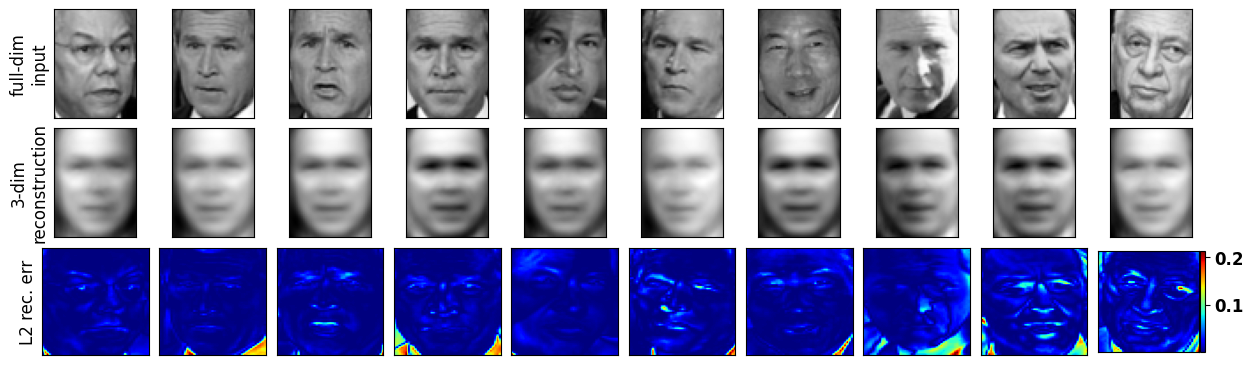

In [12]:
# LET'S TRY WITH JUST 3 COMPONENTS
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

############### Fitting with 3 components ######
pca = PCA(n_components=3) # retain 3 components
pca.fit(faces.data)
#############################################
##### Plot
# Project back to the input
projected = pca.transform(faces.data) # project with P = U_t*X_t
unprojected = pca.inverse_transform(projected) # unproject with U*P = U(U_t*X_t)
# Now plot
fig, ax = plt.subplots(3, 10, figsize=(15, 4.5),
                       subplot_kw={'xticks': [], 'yticks': []},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

# it is important to get the max value of the error so that
# we plot heatmap error with the SAME SCALE!
errors_img = [(unprojected[i]-faces.data[i])**2 for i in range(10)]
max_val = max([err.max() for err in errors_img])

for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='gray')
    ax[1, i].imshow(unprojected[i].reshape(62, 47), cmap='gray')
    erri = ax[2, i].imshow((errors_img[i]).reshape(
        62, 47), cmap='jet', extent=[0, max_val]*2)
    if i == 9:
        divider = make_axes_locatable(ax[2, i])
        cax = divider.append_axes("right", size="5%", pad=0.005)
        plt.colorbar(erri, cax=cax)

ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('3-dim\nreconstruction')
_ = ax[2, 0].set_ylabel('L2 rec. err')

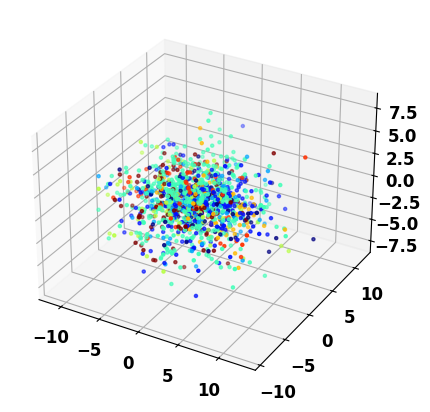

In [13]:
# Nx3
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
_ = ax.scatter(*projected.T, c=faces.target, marker='.', cmap='jet')